# <h1><center> Homework 2 Assignment </center></h1>
### <h2><center> Computer Music Representations and Models Course </center></h2>
#### <h3><center> Acoustics Engineering @ Politecnico di Milano </center></h3>
##### Paolo Ostan, paolo.ostan@mail.polimi.it
#####           Stefano Donà, stefano2.dona@mail.polimi.it


In [74]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
import IPython.display as ipd
import csv

##### Question 1

Implementation of _template based chord recognition function_. 
Given an audio file, and some control parameters as the input of the function, it is extrapolating the chord sequence using a Template-Based Pattern Matching algorithm

In [75]:
#creation of the main chord templates for the recognition algorithm 
template_cmaj = np.array([[1,0,0,0,1,0,0,1,0,0,0,0]]).T
template_cmin = np.array([[1,0,0,1,0,0,0,1,0,0,0,0]]).T

In [76]:
#function that generates a template matrix shifting chords pattern (e.g. C_maj, C_min...) in all 12 keys. 
# the function expects a matrix of dimensions (12,n) containing n possibile patterns  
def generate_template_matrix(templates):
    template_matrix = np.zeros((12,12 * templates.shape[1]))
    for shift in range(12):
        template_matrix[:, shift::12] = np.roll(templates,shift, axis = 0)
    return template_matrix

([<matplotlib.axis.XTick at 0x191847aaee0>,
 [Text(0, 0, 'C'),
  Text(1, 0, 'C#'),
  Text(2, 0, 'D'),
  Text(3, 0, 'D#'),
  Text(4, 0, 'E'),
  Text(5, 0, 'F'),
  Text(6, 0, 'F#'),
  Text(7, 0, 'G'),
  Text(8, 0, 'G#'),
  Text(9, 0, 'A'),
  Text(10, 0, 'A#'),
  Text(11, 0, 'B'),
  Text(12, 0, 'C:min'),
  Text(13, 0, 'C#:min'),
  Text(14, 0, 'D:min'),
  Text(15, 0, 'D#:min'),
  Text(16, 0, 'E:min'),
  Text(17, 0, 'F:min'),
  Text(18, 0, 'F#:min'),
  Text(19, 0, 'G:min'),
  Text(20, 0, 'G#:min'),
  Text(21, 0, 'A:min'),
  Text(22, 0, 'A#:min'),
  Text(23, 0, 'B:min')])

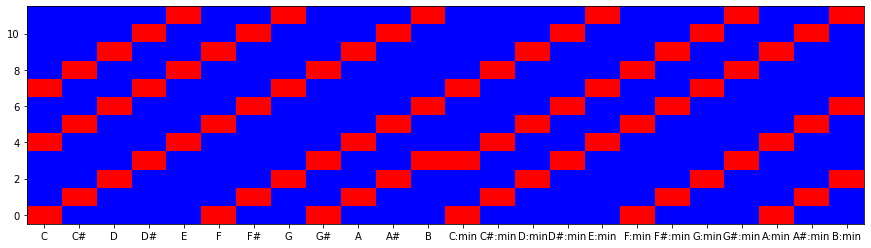

In [77]:
templates = generate_template_matrix(np.concatenate((template_cmaj,template_cmin), axis = 1))

plt.figure(figsize=(15,4))
plt.imshow(templates, origin="lower", aspect = "auto", cmap = "bwr")

chroma_labels = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')
chroma_labels_maj = chroma_labels
chroma_labels_min = [s+':min' for s in chroma_labels]
chroma_labels = np.concatenate((chroma_labels_maj, chroma_labels_min), axis = 0)
plt.xticks(np.arange(24), chroma_labels)

In [78]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Args:
        X: Feature sequence
        norm: The norm to be applied. '1', '2', 'max'
        threshold: An+ threshold below which the vector `v` used instead of normalization
        v: Used instead of normalization below `threshold`. If None, uses unit vector for given norm

    Returns:
        X_norm: Normalized feature sequence
    """
    
    K, N = X.shape
    X_norm = np.zeros((K,N))
    #print("this is K")
    #print(K)
    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in np.arange(N):
            p = np.sum(np.abs(X[:,n]))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v
                
    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in np.arange(N):
            p = np.sqrt(np.sum(X[:,n]**2))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v   
    
    if norm == 'max':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in np.arange(N):
            p = np.max(np.abs(X[:,n]))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v
    #print("this is v")
    #print(v)
    return X_norm

In [79]:
from scipy import signal

def smooth_downsample_feature_sequence(X, Fs, filt_len = 41, down_sampling = 10, w_type = 'boxcar'):
    """
    Args:
        X: Feature sequence
        Fs: Frame rate of `X`
        filt_len: Length of smoothing filter
        down_sampling: Downsampling factor
        w_type: Window type of smoothing filter

    Returns:
        X_smooth: Smoothed and downsampled feature sequence
        Fs_feature: Frame rate of `X_smooth`
        
    Hint: use numpy expand dims to obtain a window of dimension (1, L)
    """
    
    filter_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth =  signal.convolve(X, filter_kernel, mode='same') / filt_len 
    
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_down = Fs / down_sampling
    
    return X_smooth, Fs_down

In [80]:
def analysis_template_match(chromagram, templates, Fs = 22050, hop_length = 2048, norm_chromagram = '2', norm_output ='2', 
                            smoothing_window_length = None, smoothing_down_sampling = None, window_type = 'boxcar'):
    """
    Args:
        chromagram: Chromagram matrix 
        templates: Matrix containing the chroma values of all the possible applicable templates 
        Fs: Frame rate of `chromagram`
        hop_length = Size of hops 
        norm_chromagram: Type of normalization applied on chromagram, possible values: "1","2","max"
        norm_output: Type of normalization applied on chord_similarity, possible values: "1","2","max"
        smoothing_window_length: Length of smoothing filter 
        smoothing_down_sampling: Downsampling factor 
        window_type: Window type of smoothing filter

    Returns:
        chord_similarity: matrix where each box contains the value of similarity between the time quantum analyzed 
                          and the chord considered from templates matrix
        chord_max_labels: boolean matrix containing the containing in each column all the possible templates applied,
                          1 the box represents the most similar template applicable to the temporal quantum, 
                          0 otherwise
                          if more than box per column contains 1 the quantum can be considered containing silence 
        Fs_feature: Frame rate of chroma Matrices returned 
        
    """
    
    chromagram_normalized = normalize_feature_sequence(chromagram, norm_chromagram)
    H = hop_length
    Fs_chroma = Fs / H
    
    if smoothing_down_sampling and smoothing_window_length:
        chromagram_normalized, Fs_feature = smooth_downsample_feature_sequence(chromagram_normalized, Fs_chroma,
                                                                           down_sampling = smoothing_down_sampling,
                                                                          filt_len = smoothing_window_length,
                                                                          w_type = window_type)
    else:
        Fs_feature = Fs / H 
        
    template_normalized = normalize_feature_sequence(templates,    
                                                     norm = norm_chromagram)
    
    chord_similarity = np.matmul(template_normalized.T, chromagram_normalized)
    
    if norm_output:
        chord_similarity = normalize_feature_sequence(chord_similarity, norm = norm_output)
        
    chord_max_labels = (chord_similarity == chord_similarity.max(axis = 0)).astype(int) #boolean matrix
    
    
    return chord_similarity, chord_max_labels, Fs_feature


In [81]:
def computeChordListEval(filePath, Fs=22050, N=4096, H=2048, smoothing_window_length = None, smoothing_down_sampling = None, window_type = 'boxcar', norm_chromagram = '2', norm_output = 'max'):
    """
    Args:
        filePath: Path of the file to load to apply template-based recognition
        Fs: Frame rate at which the audio file is loaded
        N: FFT window size
        H: Hop length of chromagram 
        smoothing_window_length: Length of smoothing filter 
        smoothing_down_sampling: Downsampling factor
        window_type: Window type of smoothing filter
        norm_chromagram: Type of normalization applied on input chromagram, possible values: "1","2","max"
        norm_output: Type of normalization applied on chord_sim, possible values: "1","2","max"

    Returns:
        chordList: list of chord labels, where each chord, belonging to frame "n" is the most fitting template value according
                   to template-based chord recognition algorithm 
        Fs_feature: Fs_feature: Frame rate of frame based  chord recognition algorithm 
        chord_similarity: matrix where each box contains the value of similarity between the time quantum analyzed 
                          and the chord considered from templates matrix
        chord_max_labels: boolean matrix containing the containing in each column all the possible templates applied,
                          1 the box represents the most similar template applicable to the temporal quantum, 
                          0 otherwise
                          if more than box per column contains 1 the quantum can be considered containing silence 
         
        
    """
    x,Fs = librosa.load(filePath, sr=Fs)
    X = librosa.stft(x, n_fft = N, hop_length = H, pad_mode = 'constant', center = True)
    X = np.abs(X)**2
    C = librosa.feature.chroma_stft(S=X, sr = Fs, tuning = 0, hop_length = H, n_fft = N)
    
    chord_sim, chord_max, Fs_feature = analysis_template_match(C, templates, 
                                                  Fs = Fs,
                                                  hop_length = H,
                                                  smoothing_window_length = smoothing_window_length, 
                                                  smoothing_down_sampling = smoothing_down_sampling,
                                                  window_type = window_type,
                                                  norm_chromagram = norm_chromagram, 
                                                  norm_output = norm_output)
    K, N = chord_max.shape
    chordList = []
    for i in np.arange(N):
        pos = chord_max[:,i]
        maxPos = np.where(pos != 0)
        if maxPos[0].size == 1:
            chordList.append(chroma_labels[maxPos[0].item(0)])
        elif maxPos[0].size == 0:
            raise Exception("The algorithm has something wrong and can't find any value ")
        else:
            chordList.append("random")
    
    return chordList, Fs_feature, chord_sim, chord_max

([<matplotlib.axis.YTick at 0x19184760f70>,
 [Text(0, 0, 'C'),
  Text(0, 1, 'C#'),
  Text(0, 2, 'D'),
  Text(0, 3, 'D#'),
  Text(0, 4, 'E'),
  Text(0, 5, 'F'),
  Text(0, 6, 'F#'),
  Text(0, 7, 'G'),
  Text(0, 8, 'G#'),
  Text(0, 9, 'A'),
  Text(0, 10, 'A#'),
  Text(0, 11, 'B'),
  Text(0, 12, 'C:min'),
  Text(0, 13, 'C#:min'),
  Text(0, 14, 'D:min'),
  Text(0, 15, 'D#:min'),
  Text(0, 16, 'E:min'),
  Text(0, 17, 'F:min'),
  Text(0, 18, 'F#:min'),
  Text(0, 19, 'G:min'),
  Text(0, 20, 'G#:min'),
  Text(0, 21, 'A:min'),
  Text(0, 22, 'A#:min'),
  Text(0, 23, 'B:min')])

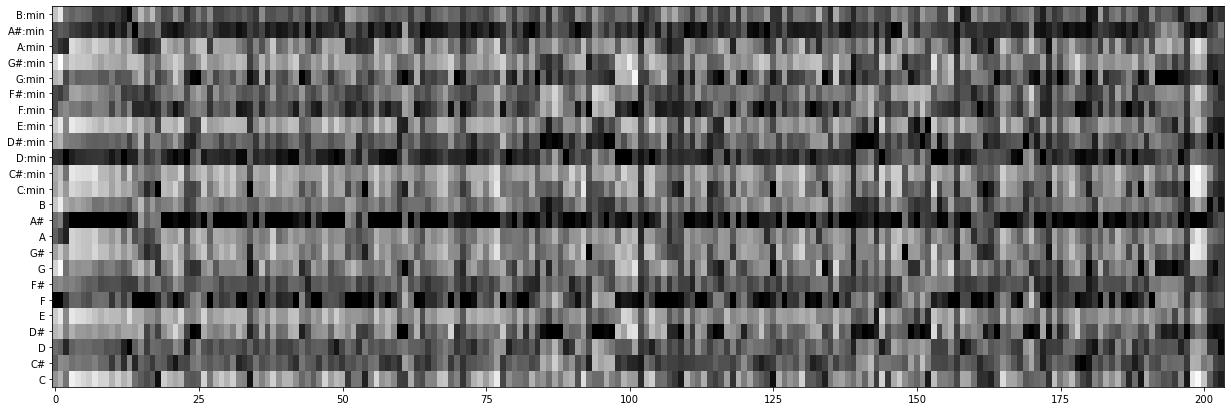

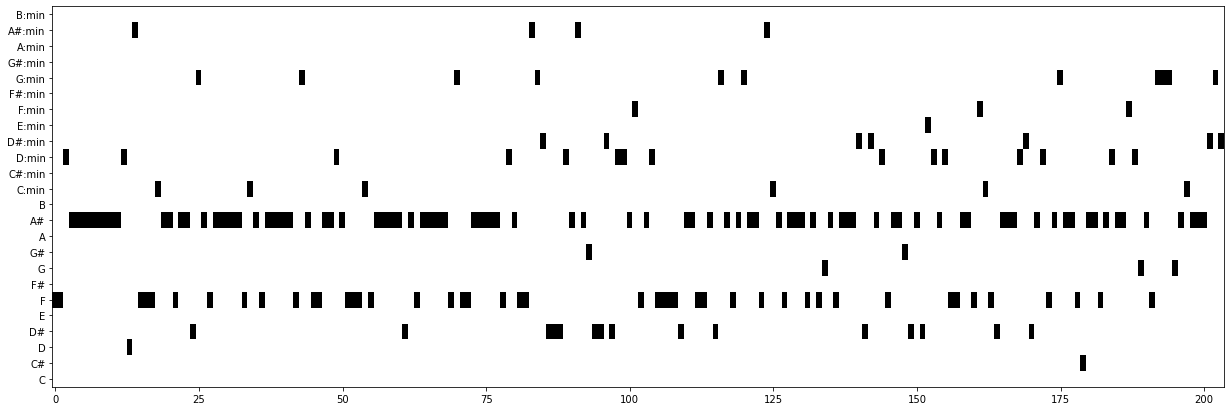

In [82]:
fn_wav = os.path.join('data', 'wav', 'Beatles_ObLaDiObLaDa.wav')
chordList, Fs_feature, chord_sim, chord_max = computeChordListEval(fn_wav, smoothing_down_sampling = 10, smoothing_window_length = 10)
fig = plt.figure(figsize=(21, 7))
plt.imshow(chord_sim, origin='lower', aspect='auto', cmap = 'gray_r')
plt.yticks(np.arange(24), chroma_labels)

fig = plt.figure(figsize=(21, 7))
plt.imshow(chord_max, origin='lower', aspect='auto', cmap = 'gray_r')
plt.yticks(np.arange(24), chroma_labels)


#### Question 2

In [83]:
def loadCSV(csvFileName, Fs_value, numOfElRef):
    
    with open(csvFileName, newline='') as csvfile:
            
        reader = csv.DictReader(csvfile)
        out_list = []
        timeAccumulator = 0
        
        for row in reader:
            # while (timeAccumulator <= float(row['End'])) or ((timeAccumulator-float(row['End'])) < (1/(2*Fs_value))):
            while (timeAccumulator <= float(row['End'])):
                out_list.append(row['Label'])
                timeAccumulator += (1/Fs_value)
            
    # if ((timeAccumulator<=float(row['End']))and(timeAccumulator-float(row['End'])) >= (1/(2*Fs_value))):
            #  out_list.append(row['Label'])
        if len(out_list) < numOfElRef:
            out_list.append(out_list[len(out_list)-1])
            
        return out_list, float(row['End'])
                


In [84]:
chroma_labels_names = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')

def stripList (chord_list, chroma_labels):
    
    comp_list = []
    chroma_labels = list(chroma_labels)
    L = len(chroma_labels)
    
    for i in np.arange(len(chord_list)):
        
        chord = chord_list[i]

        if(len(chord)>1):
            
            if (chord[1] == 'b'):
                index = (chroma_labels.index(chord[0])-1)%L
                enharmonic_chord = chroma_labels[index]
                old_chord = chord[:2]
                chord = chord.replace(old_chord, enharmonic_chord)
                
            if (('min' in chord) or ('dim' in chord)):
                index = chord.index(':')+1
                chord = chord[:index]+'min'
                comp_list.append(chord)
                
            else:
                if chord[1]=='#':
                    comp_list.append(chord[:2])
                else:
                    #print(chord)
                    comp_list.append(chord[0])

        else:
            comp_list.append(chord)
            
    return comp_list

In [85]:
def correct_strip_check(list_to_check,chroma_labels):
    correct = True
    for element in list_to_check:
        x = np.where(chroma_labels == element)
        if(x[0].size == 0):
            correct = False
    return correct

Question 3

In [86]:

def compute_goodness(chord_list, ground_truth_list):
    L = len(chord_list)
    L_gt = len(ground_truth_list)
    counter = 0
    if L==L_gt:
        for i in np.arange(len(chord_list)):
            if chord_list[i] == ground_truth_list[i]:
                counter += 1
        goodness = counter/L
        return goodness
    else:
        print('Lists must have same length!')
        print('L_chord: ', L)
        print('L_gt: ', L_gt)
        



In [87]:
# fn_wav = os.path.join('data', 'wav', 'Beatles_LetItBe.wav')
# fn_wav = os.path.join('data', 'wav', 'Beatles_HereComesTheSun.wav')
fn_wav = os.path.join('data', 'wav', 'Beatles_ObLaDiObLaDa.wav')
# fn_wav = os.path.join('data', 'wav', 'Beatles_PennyLane.wav')
obla = "./data/csv/Beatles_ObLaDiObLaDa.csv"
letit = "./data/csv/Beatles_LetItBe.csv"
here = "./data/csv/Beatles_HereComesTheSun.csv"
penny = "./data/csv/Beatles_PennyLane.csv"


chordListValue, Fs_featureVal, chords_sim, chords_max = computeChordListEval(fn_wav, Fs=11050, smoothing_window_length=41, smoothing_down_sampling=10)
myList, end = loadCSV(obla, Fs_featureVal, len(chordListValue))
#print(chordListValue)
# print(len(chordListValue))
print(Fs_featureVal)
comp = stripList (myList, chroma_labels)

isCorrect = correct_strip_check(comp,chroma_labels)
print(isCorrect)
goodness = compute_goodness(chordListValue, comp)
print(goodness)
print(comp)

0.53955078125
True
0.6176470588235294
['F', 'D', 'A#', 'A#', 'A#', 'A#', 'A#', 'F', 'F', 'F', 'A#', 'A#', 'D#', 'A#', 'A#', 'A#', 'A#', 'G:min', 'F', 'A#', 'A#', 'F', 'A#', 'A#', 'A#', 'A#', 'F', 'F', 'A#', 'A#', 'D#', 'A#', 'F', 'A#', 'A#', 'G:min', 'A#', 'A#', 'A#', 'F', 'G:min', 'F', 'A#', 'D#', 'D#', 'A#', 'A#', 'D#', 'D#', 'D#', 'A#', 'F', 'A#', 'F', 'F', 'A#', 'A#', 'A#', 'D#', 'F', 'A#', 'A#', 'F', 'A#', 'A#', 'A#', 'A#', 'G:min', 'F', 'A#', 'D#', 'D#', 'A#', 'A#', 'A#', 'D#', 'D#', 'A#', 'F', 'A#', 'F', 'F', 'F', 'A#', 'A#', 'D#', 'A#', 'A#', 'A#', 'A#', 'G:min', 'F', 'A#', 'A#', 'F', 'A#', 'F', 'G:min', 'G:min', 'A#', 'A#', 'A#']


##### Alternative more musical metrics
The following proposed metrics uses another kind of comparison with in respect with the one proposed previously:
The following metrics compares and rates the chords recognised basing what is found on the quantity of notes per chord on the quantized sample  

In [91]:
def compute_goodness_notes_based(chord_list, ground_truth_list, chroma_templates=templates, chroma_labels=chroma_labels):
    N, K = chroma_templates.shape
    print(K)
    L = len(chord_list)
    L_gt = len(ground_truth_list)
    counter = 0
    if L==L_gt:
        chromas_recognised = np.zeros((N,L),)
        chromas_ground_truth = np.zeros((N,L_gt))
        for i in np.arange(L):
            notesValue = np.where(chroma_labels == chord_list[i] )[0]
            if(len(notesValue) == 0):
                chromas_recognised[:, i] = np.zeros((1,12))
            else:
                chromas_recognised[:, i] = chroma_templates[:, notesValue[0]]
            
            notesValue_gt = np.where(chroma_labels == ground_truth_list[i])[0]

            if(len(notesValue_gt) == 0):
                chromas_ground_truth[:, i] = np.zeros((1,12))
            else:
                chromas_ground_truth[:, i] = chroma_templates[:, notesValue_gt[0]]
            
        logical_and_result = np.logical_and(chromas_recognised, chromas_ground_truth)
        unique, counts = np.unique(logical_and_result, return_counts=True)
        numOfElementsInAnd = dict(zip(unique, counts))
        unique, counts = np.unique(chromas_ground_truth , return_counts=True)
        numOfElementsInRecognised = dict(zip(unique, counts))
        goodness = numOfElementsInAnd[True]/numOfElementsInRecognised[True]

        # if (print=='1'):
        fig = plt.figure(figsize=(21, 7))
        plt.imshow(chromas_recognised, origin='lower', aspect='auto', cmap = 'gray_r')
        plt.yticks(np.arange(12), chroma_labels_names)
        plt.xticks(np.arange(L), chord_list)
        fig.suptitle('Chromas recognised')

        fig = plt.figure(figsize=(21, 7))
        plt.imshow(chromas_ground_truth, origin='lower', aspect='auto', cmap = 'gray_r')
        plt.yticks(np.arange(12), chroma_labels_names)
        plt.xticks(np.arange(L), ground_truth_list)
        fig.suptitle('Ground Truth')

        fig = plt.figure(figsize=(21, 7))
        plt.imshow(logical_and_result, origin='lower', aspect='auto', cmap = 'gray_r')
        plt.yticks(np.arange(12), chroma_labels_names)
        plt.xticks(np.arange(L), ground_truth_list)
        fig.suptitle('Logical AND result')
        
            
        return goodness
    else:
        print('Lists must have same length!')
        print('L_chord: ', L)
        print('L_gt: ', L_gt)

In [93]:

# fn_wav = os.path.join('data', 'wav', 'Beatles_LetItBe.wav')
# fn_wav = os.path.join('data', 'wav', 'Beatles_HereComesTheSun.wav')
# fn_wav = os.path.join('data', 'wav', 'Beatles_ObLaDiObLaDa.wav')
fn_wav = os.path.join('data', 'wav', 'Beatles_PennyLane.wav')
obla = "./data/csv/Beatles_ObLaDiObLaDa.csv"
letit = "./data/csv/Beatles_LetItBe.csv"
here = "./data/csv/Beatles_HereComesTheSun.csv"
penny = "./data/csv/Beatles_PennyLane.csv"



chordListValue, Fs_featureVal, chords_sim, chords_max = computeChordListEval(fn_wav, smoothing_window_length=7, smoothing_down_sampling=7)
myList, end = loadCSV(penny, Fs_featureVal,len(chordListValue))
#print(chordListValue)
# print(len(chordListValue))
# print(Fs_featureVal)
comp = stripList (myList, chroma_labels)
isCorrect = correct_strip_check(comp,chroma_labels)
print(isCorrect)
goodness = compute_goodness(chordListValue, comp)
compute_goodness_notes_based(chord_list = chordListValue, ground_truth_list = comp, print='1')
print(goodness)


True


TypeError: 'str' object is not callable

##### Question 4   


In [ ]:
chroma_labels_names = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')
songs= ['HereComesTheSun','LetItBe','ObLaDiObLaDa','PennyLane']
for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    #print(wavFile)
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    #print(sourceWav)
    computedChordList, Fs_feature, chords_sim, chords_max = computeChordListEval(sourceWav, smoothing_window_length=7, smoothing_down_sampling=7)
    ground_truth_List, timeLength = loadCSV(sourceCSV,Fs_feature,0)
    ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
    metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
    print(title + " metric goodness: " + str(metric_value))

HereComesTheSun metric goodness: 0.583916083916084
LetItBe metric goodness: 0.632
ObLaDiObLaDa metric goodness: 0.6185567010309279
PennyLane metric goodness: 0.5406360424028268


##### Question 5

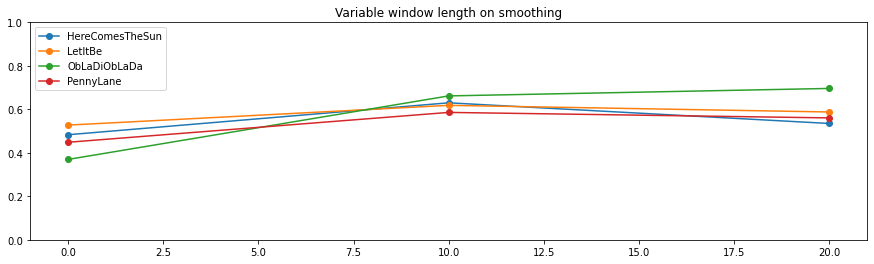

In [ ]:
chroma_labels_names = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')
songs= ['HereComesTheSun','LetItBe','ObLaDiObLaDa','PennyLane']
metric_matrix = np.zeros((3,3))

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, smoothing_window_length = 10*i,
                                                                                                 smoothing_down_sampling = 10)
        ground_truth_List, timeLength = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    k = np.arange(3)
    plt.plot(10*k, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable window length on smoothing')
plt.show()

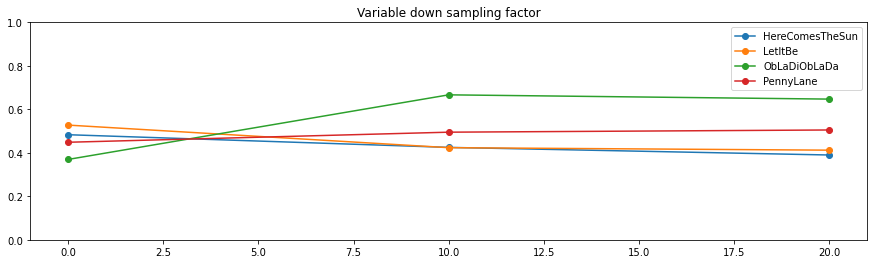

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, smoothing_window_length = 41,
                                                                                                 smoothing_down_sampling = 10*i)
        ground_truth_List, timeLength = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    k = np.arange(3)
    plt.plot(10*k, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable down sampling factor')
plt.show()

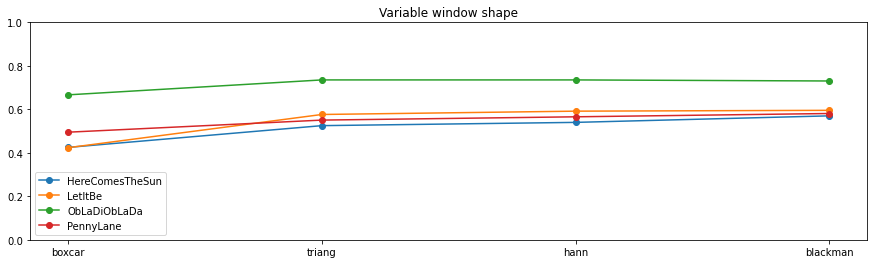

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
windows = ['boxcar', 'triang', 'hann', 'blackman']

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(4):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, smoothing_window_length = 41,
                                                                                                 smoothing_down_sampling = 10, window_type = windows[i])
        ground_truth_List, timeLength = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    k = np.arange(3)
    plt.plot(windows, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable window shape')
plt.show()

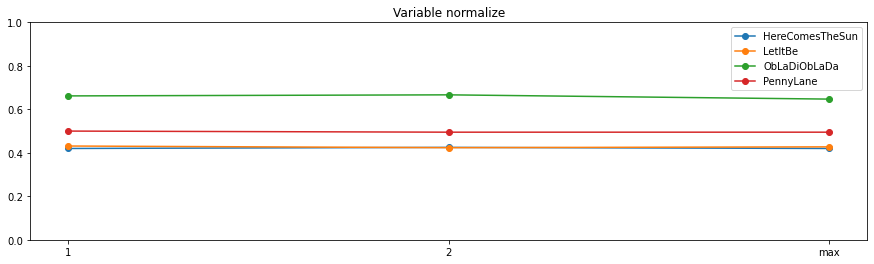

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
norm = ['1', '2', 'max']

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, 
                                                                                    smoothing_window_length = 41,
                                                                                    smoothing_down_sampling = 10,
                                                                                    window_type = 'boxcar',
                                                                                    norm_chromagram = norm[i])
        ground_truth_List, timeLength = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    # k = np.arange(3)
    plt.plot(norm, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable normalize')
plt.show()

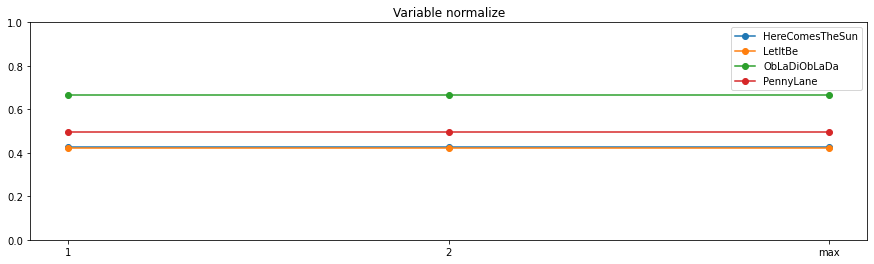

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
norm = ['1', '2', 'max']

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, 
                                                                                    smoothing_window_length = 41,
                                                                                    smoothing_down_sampling = 10,
                                                                                    window_type = 'boxcar',
                                                                                    norm_chromagram = '2',
                                                                                    norm_output = norm[i])
        ground_truth_List, timeLength = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    # k = np.arange(3)
    plt.plot(norm, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable normalize')
plt.show()

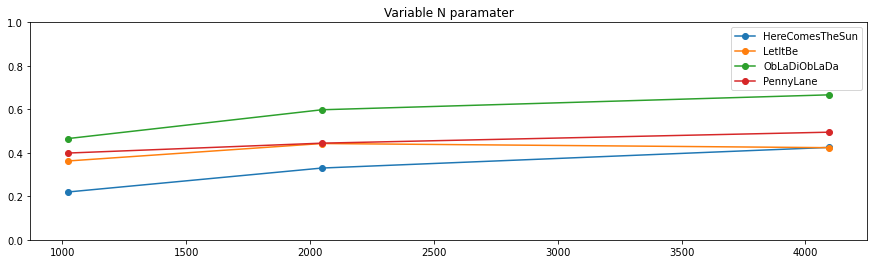

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
spls = [1024, 2048, 4096]

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, 
                                                                                    N = spls[i],
                                                                                    smoothing_window_length = 41,
                                                                                    smoothing_down_sampling = 10,
                                                                                    window_type = 'boxcar',
                                                                                    norm_chromagram = '2',
                                                                                    norm_output = 'max')
        ground_truth_List, timeLength = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    # k = np.arange(3)
    plt.plot(spls, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable N paramater')
plt.show()

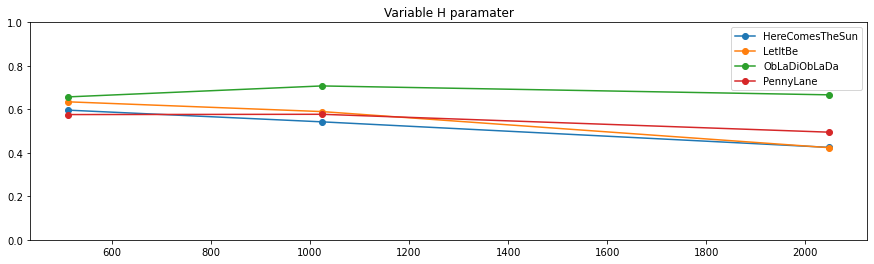

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
spls = [512, 1024, 2048]

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, 
                                                                                    H = spls[i],
                                                                                    smoothing_window_length = 41,
                                                                                    smoothing_down_sampling = 10,
                                                                                    window_type = 'boxcar',
                                                                                    norm_chromagram = '2',
                                                                                    norm_output = 'max')
        ground_truth_List, timeLength = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    # k = np.arange(3)
    plt.plot(spls, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable H paramater')
plt.show()

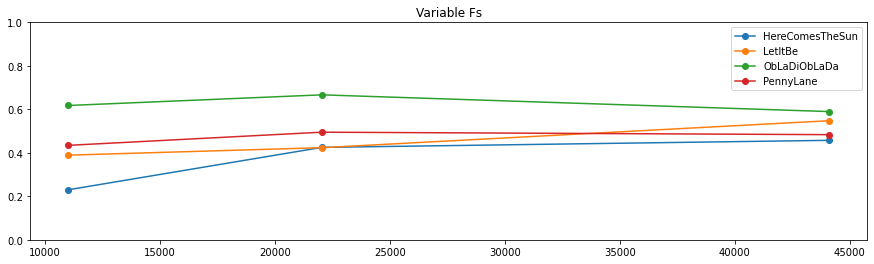

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
freq = [11025, 22050, 44100]

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, 
                                                                                    Fs = freq[i],
                                                                                    smoothing_window_length = 41,
                                                                                    smoothing_down_sampling = 10,
                                                                                    window_type = 'boxcar',
                                                                                    norm_chromagram = '2',
                                                                                    norm_output = 'max')
        ground_truth_List, timeLength = loadCSV(sourceCSV, Fs_feature, len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    # k = np.arange(3)
    plt.plot(freq, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable Fs')
plt.show()